In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [72]:
import os
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.optim as optim

In [73]:
torch.manual_seed(42)

In [74]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",DEVICE)

Device: cuda


In [75]:
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform 
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        row = self.df.iloc[index]
        img_path = os.path.join(self.img_dir,row['id_code']+'.png')
        img = Image.open(img_path).convert('RGB')
        label = int(row['diagnosis'])

        if self.transform:
            img = self.transform(img)

        return img, label
            
        

In [76]:
img_size = 265

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),      
    transforms.RandomHorizontalFlip(),            
    transforms.RandomRotation(15),                
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),  
    transforms.ToTensor(),                        
    transforms.Normalize([0.485, 0.456, 0.406],   
                         [0.229, 0.224, 0.225])  
])


val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [77]:
train_img_path = "/kaggle/input/aptos2019-blindness-detection/train_images"
train_csv_path = "/kaggle/input/aptos2019-blindness-detection/train.csv"

In [78]:
full_dataset = RetinopathyDataset(train_csv_path, train_img_path)

In [79]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

In [80]:
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

In [81]:
train_dataloader = DataLoader(train_ds, batch_size=32,shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True)

In [82]:
# model --> mobilenetV3
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

mobileNet_small = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

In [83]:
mobileNet_small.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [84]:
for param in mobileNet_small.features.parameters():
    param.requires_grad = False

In [85]:
mobileNet_small.classifier = nn.Sequential(
    nn.Linear(576,out_features=288),
    nn.Hardswish(),
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(288,out_features=5)
)

In [86]:
mobileNet_small = mobileNet_small.to(DEVICE)

In [87]:
# hyperparameters
learning_rate = 0.0001
epochs = 10

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobileNet_small.classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

In [89]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=False):
     
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved. Counter reset to 0.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss did not improve. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [91]:
import torch.nn as nn
import torch.optim as optim
import copy

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize early stopping with your desired patience
early_stopping = EarlyStopping(patience=5, verbose=True)

# To save the best model weights
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(mobileNet_small.state_dict())

epochs = 10

for epoch in range(epochs):
    # --- Training Phase ---
    mobileNet_small.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = mobileNet_small(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_acc = 100 * correct_train / total_train
    
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation Phase ---
    mobileNet_small.eval()  # Set the model to evaluation mode
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs_val, labels_val in val_dataloader:
            inputs_val, labels_val = inputs_val.to(DEVICE), labels_val.to(DEVICE)
            
            outputs_val = mobileNet_small(inputs_val)
            loss_val = criterion(outputs_val, labels_val)
            
            running_loss_val += loss_val.item()
            
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    epoch_val_loss = running_loss_val / len(val_dataloader)
    epoch_val_acc = 100 * correct_val / total_val
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")
    
    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(mobileNet_small.state_dict())
    
    # Check for early stopping
    early_stopping(epoch_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model weights after training
mobileNet_small.load_state_dict(best_model_wts)
print("Best model weights loaded.")

Epoch 1/10 | Train Loss: 0.9440 | Train Acc: 69.34% | Val Loss: 0.9885 | Val Acc: 65.35%
Validation loss improved. Counter reset to 0.
Epoch 2/10 | Train Loss: 0.8337 | Train Acc: 71.42% | Val Loss: 0.9096 | Val Acc: 66.98%
Validation loss improved. Counter reset to 0.
Epoch 3/10 | Train Loss: 0.7682 | Train Acc: 72.58% | Val Loss: 0.7809 | Val Acc: 70.94%
Validation loss improved. Counter reset to 0.
Epoch 4/10 | Train Loss: 0.7340 | Train Acc: 72.96% | Val Loss: 0.7085 | Val Acc: 74.08%
Validation loss improved. Counter reset to 0.
Epoch 5/10 | Train Loss: 0.6962 | Train Acc: 73.71% | Val Loss: 0.6680 | Val Acc: 75.17%
Validation loss improved. Counter reset to 0.
Epoch 6/10 | Train Loss: 0.6638 | Train Acc: 75.21% | Val Loss: 0.6391 | Val Acc: 75.72%
Validation loss improved. Counter reset to 0.
Epoch 7/10 | Train Loss: 0.6621 | Train Acc: 75.45% | Val Loss: 0.6298 | Val Acc: 76.13%
Validation loss improved. Counter reset to 0.
Epoch 8/10 | Train Loss: 0.6447 | Train Acc: 75.73% | V

In [92]:
torch.save(mobileNet_small.state_dict(), '/kaggle/working/best_mobilenet_model.pth')

{'prediction': 'Mild DR', 'confidence': 0.3188275992870331}


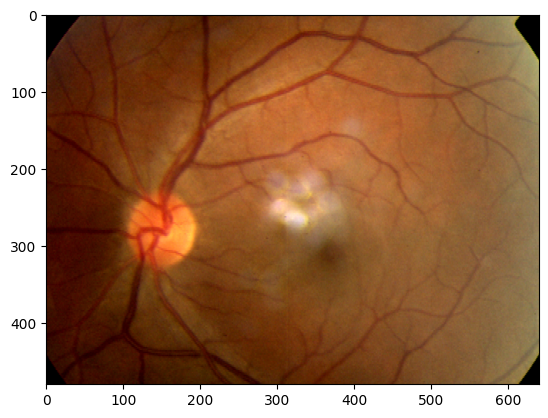

In [111]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# NUM_CLASSES = 5
# loaded_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
# loaded_model.classifier = nn.Sequential(
#     nn.Linear(576, out_features=288),
#     nn.Hardswish(),
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(288, out_features=NUM_CLASSES)
# )

# # Load the saved state dictionary
# model_path = 'best_mobilenet_model.pth' # Replace with the correct path to your saved model
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model.eval() # Important! Set model to evaluation mode

# # Use GPU if available
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# loaded_model = loaded_model.to(DEVICE)


def inference_on_image(image_path):
    """
    Performs inference on a single image using the loaded model.
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img)

    # Add a batch dimension (B x C x H x W)
    img_tensor = img_tensor.unsqueeze(0)
    
    # Move the tensor to the correct device
    img_tensor = img_tensor.to(DEVICE)
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        outputs = mobileNet_small(img_tensor)
    
    # Get the predicted probabilities from the model's raw output
    probabilities = nn.functional.softmax(outputs, dim=1)[0]
    
    # Get the class with the highest probability
    predicted_class_index = torch.argmax(probabilities).item()
    confidence = probabilities[predicted_class_index].item()
    
    # Map the class index to a label
    class_labels = ["No DR", "Mild DR", "Moderate DR", "Severe DR", "Proliferative DR"]
    predicted_label = class_labels[predicted_class_index]
    
    return {
        "prediction": predicted_label,
        "confidence": confidence,
        # "class_probabilities": probabilities.tolist()
    }

def visualize(img_path):
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)

# Example usage:
image_to_test = '/kaggle/input/aptos2019-blindness-detection/test_images/0167076e7089.png' # Change this to your image path
visualize(image_to_test)
results = inference_on_image(image_to_test)
print(results)

In [ ]:
!pip install grad-cam

Using device: cuda
Model predicted class: 0


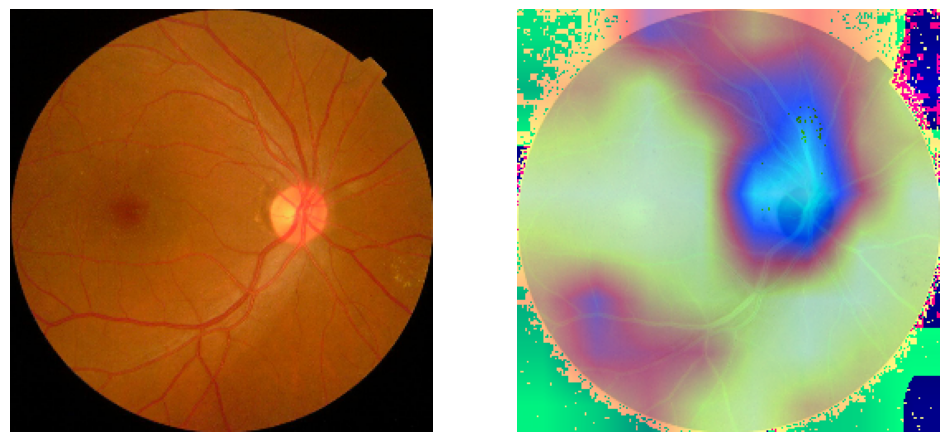

Heatmap saved to cam_output.jpg


In [19]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# --- Model and Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Re-create the model architecture as you defined it
num_classes = 5
model = mobilenet_v3_small()
in_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, out_features=288),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(288, out_features=num_classes)
)

# Load the trained weights
model_path = '/kaggle/input/mobile_net_small/pytorch/default/1/best_mobilenet_model.pth' 
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# --- Image Preprocessing ---
# This must match your training data transformations exactly
image_path = '/kaggle/input/aptos2019-blindness-detection/test_images/0299d97f31f7.png'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

rgb_img = np.float32(Image.open(image_path).convert('RGB')) / 255
rgb_img = cv2.resize(rgb_img, (256, 256))
input_tensor = transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(DEVICE)

# --- Grad-CAM Configuration ---
# The target layer is the last convolutional layer in the feature extractor.
# For MobileNetV3, this is the last block of the 'features' module.
target_layer = model.features[-1]

# Get the predicted class to use as the target for the heatmap
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()
print(f"Model predicted class: {predicted_class}")
targets = [ClassifierOutputTarget(predicted_class)]

# Construct the Grad-CAM object without the 'use_cuda' argument
# The library now handles device selection automatically
cam = GradCAM(model=model, target_layers=[target_layer])

# Generate the heatmap
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Overlay the heatmap on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# --- Display and Save Results ---
# Convert the visualization to a format that can be saved with OpenCV
vis_bgr = cv2.cvtColor(np.uint8(255 * visualization), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.axis("off")  

plt.subplot(1,2,2)
vis_bgr1= cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(vis_bgr1)
plt.axis("off")   

plt.show()


cv2.imwrite('cam_output.jpg', vis_bgr)
print("Heatmap saved to cam_output.jpg")